# Classificação de galáxias usando Machine Learning

- PET - Física
- Petiano: Gabriel Wendell Celestino Rocha
- Data: 28 de Setembro de 2022

O objetivo deste `Notebook` é servir como um complemento ao `Notebook` *Classificação espectral usando Machine Learning* [1]. No `Notebook` mencionado foi abordado alguns algoritmos de ML para mineração de dados tabulares. Neste `Notebook` iremos nos aprofundar um pouco mais no assunto e partiremos para o tratamento de imagens usando algoritmos de redes neurais e redes profundas.

Para uma melhor organização deste `Notebook` como um todo, este foi dividido em quatro seções:

1. ***Machine Learning* aplicado à imagens**;
2. **Saco de dicas e truques**;
3. **Indo um pouco mais fundo...**;
4. **Ao infinito e além!**.

## Pré-requisitos

Este `Notebook` assume que o leitor esteja ao menos um pouco familiarizado com o Python e seu ecossistema de computação científica, além dos conceitos básicos de *Machine Learning*. Em particular, este `Notebook` decorreu de uma inspiração do minicurso [*Uma breve introdução ao Machine Learning*](https://petfisica.home.blog/2022/06/29/minicursos-do-pet-uma-breve-introducao-ao-machine-learning/) ofertado pelo PET - Física da UFRN. Além disso, é recomendável que o leitor tenha lido o `Notebook` [Classificação espectral de estrelas usando Machine Learning](https://github.com/GabrielWendell/PET.py/blob/main/Notebooks/Classificação%20espectral%20estelar%20usando%20ML.ipynb) [1] uma vez que este visa servir como uma complementação do `Notebook` mencionado.

### Importando as bibliotecas

In [1]:
from skimage import data, exposure
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import pandas as pd
import numpy as np

from torch import nn
import sklearn
import skorch
import torch
import h5py

%matplotlib inline

def opt_plot():
    # plt.style.use('dark_background')
    plt.grid(True, linestyle = ':', color='0.50')
    plt.minorticks_on()
    plt.tick_params(axis = 'both', which = 'minor', direction = "in",
                        top = True, right = True, length = 5, width = 1, labelsize = 15)
    plt.tick_params(axis = 'both', which = 'major', direction = "in",
                        top = True, right = True, length = 8, width = 1, labelsize = 15)
    
import warnings
warnings.filterwarnings('ignore')

#### Detalhes das bibliotecas:

In [2]:
%load_ext version_information
%version_information H5py, Matplotlib, Numpy, Pandas, Seaborn, Scikit-image, Scikit-learn, Skorch, Torch

Software,Version
Python,3.9.8 64bit [MSC v.1929 64 bit (AMD64)]
IPython,8.0.1
OS,Windows 10 10.0.19044
H5py,3.6.0
Matplotlib,3.5.1
Numpy,1.22.2
Pandas,1.4.0
Seaborn,0.11.2
Scikit-image,0.19.3
Scikit-learn,1.1.1


Para instalar a magic extension `%version_information` do `IPython` usando o `pip`, execute a seguinte linha de comando em um terminal de sua preferência:

```Python
$ pip install version_information
```

Dado o exposto, vamos ao `Notebook` propriamente dito.

---

## 1. *Machine Learning* aplicado à imagens

No [`Notebook`](https://github.com/GabrielWendell/PET.py/blob/main/Notebooks/Classificação%20espectral%20estelar%20usando%20ML.ipynb) [1] vimos como realizar aprendizado de máquina em dados tabulares, ou seja, dados unidimensionais. Os dados tabulares geralmente são estruturados, o que significa que as colunas são conhecidas por serem significativas de uma forma ou de outra. A informação bruta já foi processada e sintetizada em um catálogo.

Mas e se quisermos voltar à fonte? A visão computacional fornece um conjunto diversificado de ferramentas extraídas de processamento de imagens e aprendizado de máquina que podem ajudar a realizar mineração de dados em grandes coleções de imagens.

```Python
In [3]:
urllib.request.urlretrieve("http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5", "Galaxy10.h5")

Out[3]:
('Galaxy10.h5', <http.client.HTTPMessage at 0x7fc00bfa8240>)
```

O conjunto de dados que baixamos vem do [pacote `astroNN`](https://astronn.readthedocs.io/en/latest/galaxy10.html). É baseado na [coleção Galaxy Zoo](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/), que https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/usa imagens do *Sloan Digital Sky Survey* (SDSS). Vamos conferir como são as imagens.

Vamos avaliar as imagens e rótulos são armazenados no formato `HDF5`, mas podemos usar arquivos simples

In [3]:
with h5py.File('Galaxy10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'], dtype = 'int64')

print(f"Galaxy10 dataset: {len(images)} imagens e {len(np.unique(labels))} classes")

Galaxy10 dataset: 21785 imagens e 10 classes


Estamos lidando com imagens coloridas de galáxias 69x69. O objetivo do conjunto de dados `Galaxy10` é realizar a classificação dessas imagens em uma das 10 formas de galáxias definidas a seguir:

In [4]:
class_names = [
    "Disk, Face-on, No Spiral",
    "Smooth, Completely round",
    "Smooth, in-between round",
    "Smooth, Cigar shaped",
    "Disk, Edge-on, Rounded Bulge",
    "Disk, Edge-on, Boxy Bulge",
    "Disk, Edge-on, No Bulge",
    "Disk, Face-on, Tight Spiral",
    "Disk, Face-on, Medium Spiral",
    "Disk, Face-on, Loose Spiral"
]

Podemos exibir usando o Matplotlib um exemplo de cada classe:

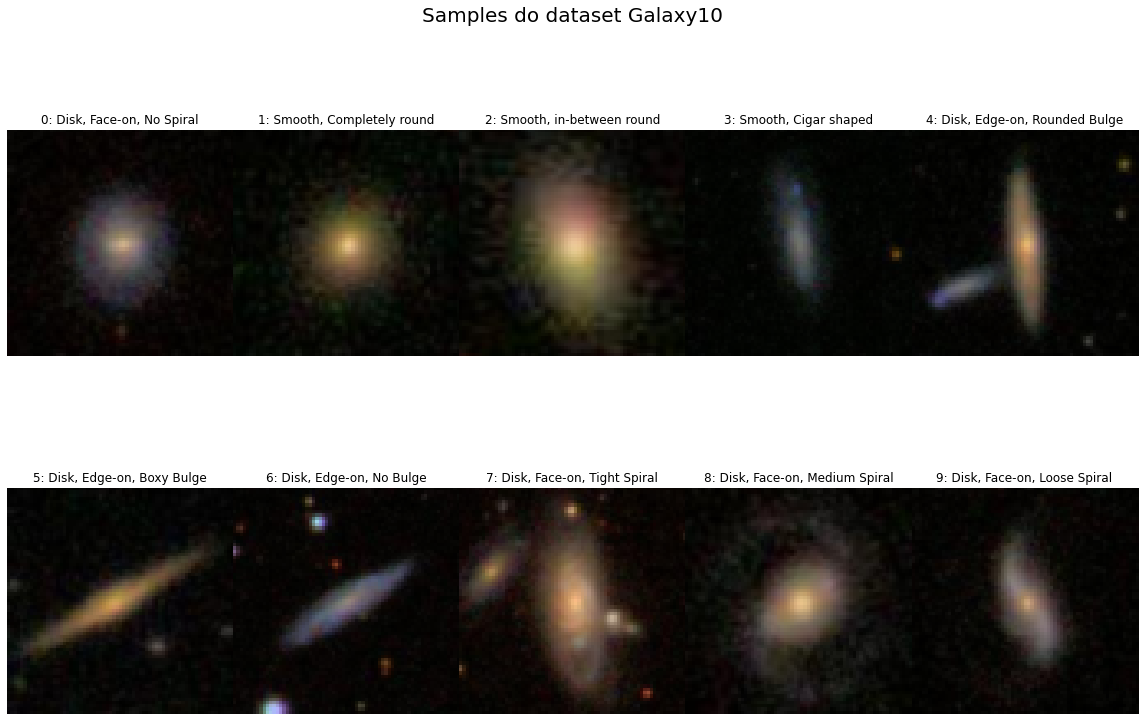

In [5]:
_, demo_idx = np.unique(labels, return_index=True)

fig = plt.figure(figsize = (16, 12))
for idx, (img, label) in enumerate(zip(images[demo_idx], labels[demo_idx])):
    fig.add_subplot(2, 5, idx + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{label}: {class_names[label]}")
fig.tight_layout(h_pad = 0, w_pad = 0)
plt.suptitle("Samples do dataset Galaxy10", fontsize = 20)

plt.savefig('Samples do dataset Galaxy10.png', dpi = 400) and plt.show()

Como de costume, dividiremos o conjunto de dados em dois. Nesse caso, usaremos 60% das imagens para treinamento e os 40% restantes para teste.

In [6]:
from sklearn.model_selection import train_test_split

images_train, images_test, y_train, y_test = train_test_split(images.astype('float32'), labels, train_size = 0.6)

### 1.1 Recursos de imagem padrão

Ao trabalhar com imagens, a abordagem padrão para reconhecimento de objetos era usar os chamados descritores de recursos. Esses descritores são uma forma de descrever algumas propriedades da imagem em um vetor compactado com uma dimensão menor que a matriz da imagem completa. Exemplos de tais descritores são a [decomposição wavelet](https://www.sciencedirect.com/topics/mathematics/discrete-wavelet-transform) [2] ou [histogramas de cores](https://datacarpentry.org/image-processing/05-creating-histograms/) [3].

Esses descritores são então usados em vez da imagem como recursos para modelos de ML. Esta seção ilustra como aplicar esse pipeline no conjunto de dados Galaxy10.

### 1.2 HOG + SVM

O histograma de gradientes orientados (HOG, ou *Histogram of Oriented Gradients*) é um descritor de características clássico para imagens. É muito popular em visão computacional para detecção e classificação de objetos. A ideia central é que a imagem seja dividida em blocos. Em cada bloco, os gradientes serão calculados para diferentes orientações.

O algoritmo HOG foi introduzido por [Navneet Dalal e Bill Triggs em 2005 para detecção de pedestres](https://hal.inria.fr/inria-00548512/document) [4].

A biblioteca [`scikit-image`](https://scikit-image.org) tem suporte integrado para HOG. Um pipeline comum para classificação de imagens é o chamado pipeline HOG+SVM. É composto por duas etapas:

1. extrair HOG de todas as imagens (isso produz um vetor de recursos 1D para todas as imagens);
2. treinar um SVM nos recursos HOG.

In [7]:
from skimage.feature import hog
from tqdm.notebook import tqdm

def hog_galaxy10(image):
    # Calcula o histograma de gradientes orientados em uma imagem
    # Usamos 8 orientações e 8 pixels em uma célula/bloco
    return hog(image, orientations = 8, pixels_per_cell = (8, 8), cells_per_block = (1,1), multichannel = True)

Extraimos então o HOG nas imagens de treinamento e teste (essa etapa irá levar alguns segundos):

In [8]:
X_train = np.array([hog_galaxy10(image) for image in tqdm(images_train, desc = "HOG em treino")], dtype = 'float32')
X_test = np.array([hog_galaxy10(image) for image in tqdm(images_test, desc = "HOG em teste")], dtype = 'float32')

HOG em treino:   0%|          | 0/13071 [00:00<?, ?it/s]

HOG em teste:   0%|          | 0/8714 [00:00<?, ?it/s]

Como exemplo, podemos produzir uma visualização 2D do que o HOG "vê" na imagem:

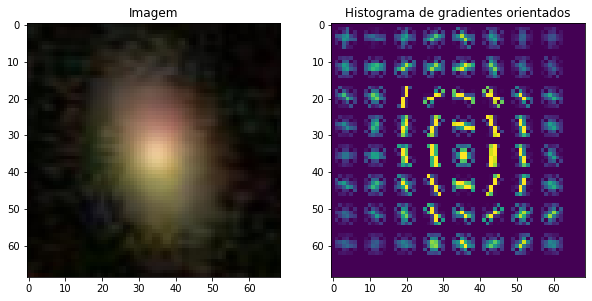

In [9]:
feat, hog_image = hog(images[0], orientations = 8, pixels_per_cell = (8, 8), cells_per_block = (1,1), 
                      multichannel = True, visualize = True)

fig = plt.figure(figsize = (10, 10))
fig.add_subplot(121)
plt.imshow(images[0])
plt.title("Imagem")
fig.add_subplot(122)
hog_image = exposure.rescale_intensity(hog_image, in_range = (0, 10))
plt.imshow(hog_image)
plt.title("Histograma de gradientes orientados")

plt.savefig('Imagem X Histograma.png', dpi = 400) and plt.show()

Vamos agora avaliar a eficiência do nosso modelo:

In [10]:
from sklearn.svm import LinearSVC

svm = LinearSVC(max_iter = 2000)
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

0.5944457195317879

**Dica 3**: você nem sempre precisa de aprendizado profundo. Sempre use uma linha de base simples para garantir que sua rede profunda realmente tenha um desempenho melhor.

### 1.3 HOG + redes neurais

Algumas redes neurais podem ser usadas como substitutos imediatos para modelos tradicionais de ML. Na verdade, redes neurais simples têm sido usadas desde os anos 60. Embora o `sklearn` implemente algumas redes neurais básicas (chamadas de *Multilayer Perceptron* ou MLP), não vamos usá-lo, pois ele não suporta aceleração de GPU. Em vez disso, vamos usar a biblioteca de computação tensorial com o [`PyTorch`](https://pytorch.org).

Em seu núcleo, `PyTorch` e [`Tensorflow`](https://www.tensorflow.org/?gclid=CjwKCAjwm8WZBhBUEiwA178UnHS40oQG1UrzA6kepDTimvgY58eP1o8n3FRBnZSjIrBa9BplNPlKbRoC7EgQAvD_BwE) são bibliotecas genéricas de computação de tensor (semelhante ao `NumPy`) que suportam aceleração de GPU para computação mais rápida. No entanto, essas bibliotecas foram projetadas com o aprendizado profundo em mente, o que significa que também suportam diferenciação automática (necessária para treinar redes neurais usando retropropagação) e expõem funções úteis para definir redes neurais.

Começaremos importando a biblioteca `torch` e o *wrapper skorch*. Como veremos, o [`skorch`](https://skorch.readthedocs.io/en/stable/) é um wrapper em torno de torch que transforma redes neurais definidas com torch em objetos Python que seguem a mesma interface dos modelos [`scikit-learn`](https://scikit-learn.org/stable/). Isso facilita muito o trabalho, passando de ML superficial para aprendizado profundo.

Para fins de reprodutibilidade, definimos manualmente a semente do gerador de números aleatórios:

In [11]:
torch.manual_seed(0)

As redes neurais podem ser computacionalmente caras. Para reduzir o tempo de computação, podemos usar aceleradores como Unidades de Processamento Gráfico (GPU). Originalmente projetadas para renderização 3D e jogos, as GPUs são muito eficazes para multiplicação de matrizes paralelas.

A próxima célula de código verifica se uma GPU NVIDIA que suporta aceleração CUDA está disponível. Caso contrário, o código do `torch` será executado na CPU (e será cerca de 10x mais lento).

Dito isso, vamos verificar se a GPU está disponível, caso contrário vamos recuá-la na CPU:

In [12]:
# device = 'cuda' if torch.cuda.is_available else 'cpu'
device = 'cpu'

Vamos definir uma rede neural simples. A construção de redes neurais às vezes pode parecer LEGO, onde você empilha camadas de funções predefinidas.

A camada mais básica é a `Linear` (ou camada *totalmente conectada*). Ele recebe como entrada um vetor $X\in\mathbb{R}^{p}$ e produz um vetor $Z\in\mathbb{R}^{q}$. Fundamentalmente, esta é uma multiplicação de matrizes: $Z=W\cdot X+b$.

Todos os neurônios (valores) de $X$ estão conectados a cada neurônio de $Z$. Os pesos $w_{i,j}$ da matriz $W$ definem o peso das $p\times q$ conexões sinápticas. Além disso, $b$ é um vetor de polarização constante.

**Aviso**: A matriz $W$ pode se tornar muito grande (mais de 1 milhão de parâmetros) quando $p$ e $q$ crescem.

A camada `Linear` é, na verdade, a rede neural mais básica do que você pode imaginar. Nos anos 60, era chamado de **Perceptron**. No livro [*Perceptrons* (1969)](https://mitpress.mit.edu/9780262630221/perceptrons/) [5], Marvin Minsky e Seymour Papert observaram que, como a relação entre $Z$ e $X$ é linear, o Perceptron tem uma capacidade muito limitada (por exemplo, um Perceptron não pode aproximar a função XOR).

Mas e se adicionarmos mais camadas? Bem, $Z=W_1\cdot W_2\cdot W_3\cdot X$ ainda é uma única multiplicação de matriz linear. O truque é adicionar **não linearidades** entre as camadas.

Vagamente semelhante ao que acontece em neurônios biológicos, agora diremos que a saída de um neurônio é a soma de suas entradas ponderadas **passadas por uma função de ativação não linear**. Qualquer função não linear diferenciável serve, mas na maioria das vezes usamos a ativação ReLU de [Glorot *et al*., 2011](http://proceedings.mlr.press/v15/glorot11a/glorot11a.pdf) [6].

$$\text{Re}LU:x\rightarrow\text{max.}(0,x)$$

Agora podemos definir um MultiLayer Perceptron (MLP) não linear. Existem várias maneiras de definir uma rede neural no `PyTorch`. Para modelos simples, a abordagem mais rápida é usar a API `Sequential`.

In [13]:
mlp = nn.Sequential(
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10))

A função `mlp` agora define um objeto de rede neural do torch. Usando o `skorch`, definiremos um estimador semelhante aos objetos anteriores que usamos no scikit-learn:

In [14]:
nn_classifier = skorch.classifier.NeuralNetClassifier(mlp,
                                                      lr = 0.05,                         # Taxa de Aprendizagem
                                                      max_epochs = 50,                   # Número de épocas
                                                      criterion = nn.CrossEntropyLoss,   # Função de Perda
                                                      device = device)                   # Execute na GPU ou CPU

Damos ao `skorch` alguns hiperparâmetros, a saber:

- a função de perda que queremos minimizar. No nosso caso, usamos a perda de entropia cruzada que é a mais comum para classificação.
- a taxa de aprendizado, que define a amplitude do passo no algoritmo de treinamento de gradiente descendente.
- os parâmetros `max_epochs` que definem por quanto tempo a rede será treinada. Com `max_epochs = 20`, o modelo verá todas as amostras no conjunto de dados de treinamento 20 vezes.

Agora que definimos nossa rede neural usando `skorch`, podemos usar os métodos `fit` e `score` como antes.

In [15]:
nn_classifier.fit(X_train, y_train)
nn_classifier.score(X_test, y_test)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.8368       0.3228        1.7267  2.1921
      2        1.7122       0.3228        1.6926  2.2117
      3        1.6633       0.3228        1.6212  2.3120
      4        1.5778       0.3579        1.5310  2.3050
      5        1.5126       0.3759        1.4683  2.2470
      6        1.4851       0.3924        1.4290  2.1986
      7        1.4625       0.4218        1.3975  2.3450
      8        1.4437       0.4677        1.3720  2.2690
      9        1.4252       0.4826        1.3459  2.2770
     10        1.4045       0.5006        1.3222  2.2670
     11        1.3818       0.5239        1.2985  2.3709
     12        1.3577       0.5426        1.2743  2.2540
     13        1.3326       0.5560        1.2489  2.3370
     14        1.3067       0.5675        1.2211  2.3700
     15        1.2789       0.5759        1.1907  2.3000
     16        1.2482       0.5

0.686022492540739

Feito! Agora treinamos nossa primeira rede neural. À primeira vista, ele tem um desempenho significativamente melhor nos recursos HOG do que a linha de base do SVM (mas lembre-se de que não ajustamos os hiperparâmetros do SVM, portanto, é uma linha de base pessimista).

**Dica 4**: o `skorch` permite que você use redes neurais profundas da mesma forma que os modelos `scikit-learn`.

Podemos plotar ambas as matrizes de confusão para comparar os modelos.

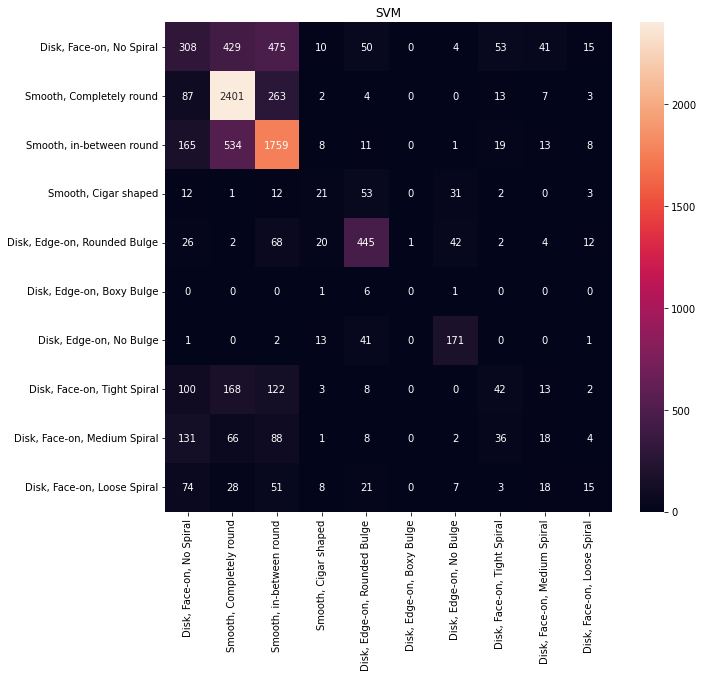

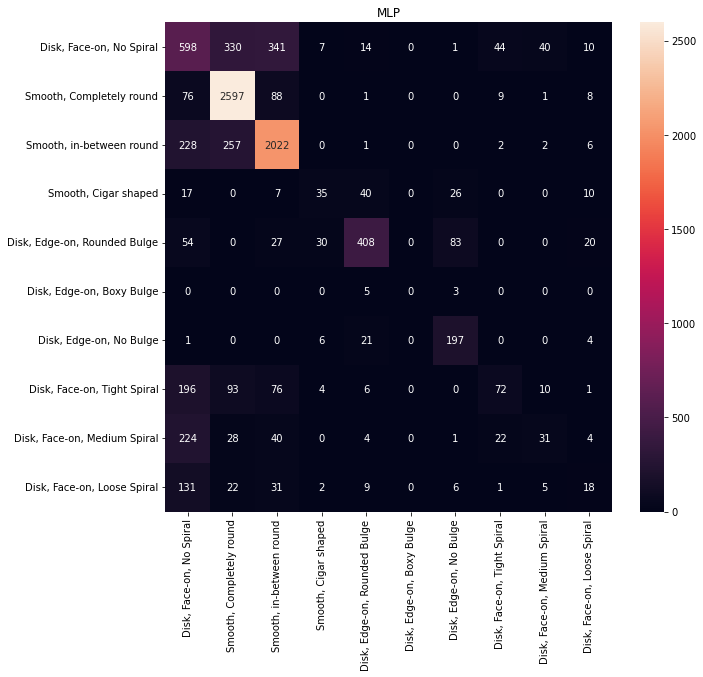

In [16]:
def show_G10_results(y_pred, y_test, title=None):
    cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize = (10, 9))
    sns.heatmap(cm, annot = True, fmt = 'd', xticklabels=class_names, yticklabels = class_names )
    if title is not None:
        plt.title(title)
        plt.savefig('Matriz de confusão - ' + title, spi = 400)
    plt.show()

show_G10_results(svm.predict(X_test), y_test, title = "SVM")
show_G10_results(nn_classifier.predict(X_test), y_test, title = "MLP")

### 1.4 Redes Neurais Convolucionais

O estado da arte atual para classificação de imagens é a Rede Neural Convolucional (*Convolutional Neural Network*, ou CNN). Os fundamentos desta arquitetura foram introduzidos por [Yann Lecun *et al.* em 1998](http://yann.lecun.com/exdb/lenet/) [7] para reconhecimento de caracteres escritos.

A ideia subjacente à CNN é que redes totalmente conectadas são ineficientes para dados de imagem, pois o vetor de entrada seria muito grande (uma imagem de 69 x 69 x 3 = 14.283 valores de entrada). Uma camada oculta com uma quantidade moderada de neurônios se tornaria enorme (com 500 neurônios, isso resulta em mais de 7 milhões de parâmetros).

Os kernels convolucionais podem ser compartilhados e usados ​​para todos os pixels da imagem. Podemos realizar várias convoluções na imagem para obter vários resultados de filtragem. Então, podemos aplicar uma ativação não linear (o mesmo que no MLP) e empilhar um novo conjunto de convoluções.

Essa pilha de convoluções alternadas e não linearidades forma o básico da CNN.

Primeiro, transpomos a imagem do formato HxWxC (*channels last*, ou canais por último) para o formato CxHxW (*channels first*, ou canais primeiro). A maioria das estruturas de aprendizado profundo, como o `PyTorch`, usa o último.

In [17]:
images_train = images_train.transpose(0, 3, 1, 2)
images_test = images_test.transpose(0, 3, 1, 2)

cnn = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size = (3,3), padding = 1),
    nn.MaxPool2d(kernel_size = (2, 2)),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size = (3,3), padding = 1),
    nn.MaxPool2d(kernel_size = (2, 2)),
    nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size = (3,3), padding = 1),
    nn.MaxPool2d(kernel_size = (2, 2)),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size = (3,3), padding = 1),
    nn.MaxPool2d(kernel_size = (2, 2)),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size = (3,3), padding = 1),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(256, 10)
)

cnn_classifier = skorch.classifier.NeuralNetClassifier(cnn,
                                                       lr = 0.005,
                                                       optimizer__momentum = 0.9,
                                                       max_epochs = 20,
                                                       criterion = nn.CrossEntropyLoss,
                                                       device = device)
cnn_classifier.fit(images_train, y_train)

  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        1.7254       0.3304        1.5729  177.5484
      2        1.5252       0.3568        1.5094  168.7364
      3        1.4238       0.4489        1.2963  168.6316
      4        1.3016       0.4853        1.2719  180.5492
      5        1.1891       0.5281        1.1591  201.7640
      6        1.0770       0.5813        1.0178  194.3352
      7        0.9914       0.5503        1.1841  185.8457
      8        0.9457       0.6252        0.9365  204.7467
      9        0.8014       0.6960        0.8003  185.5113
     10        0.7540       0.7044        0.8102  169.9034
     11        0.7083       0.7224        0.7311  168.1832
     12        0.6799       0.7055        0.8030  166.3080
     13        0.6506       0.7044        0.8144  172.0068
     14        0.6252       0.7350        0.7825  169.2711
     15        0.5978       0.7411        0.7796  166.05

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): AdaptiveAvgPool2d(output_size=(1, 1))
    (14): Flatten(start_dim=1, end_dim=-1)
 

Para testar a rede, podemos fazer uma passagem direta em uma imagem de amostra. Por exemplo, vamos pegar a imagem nº 174 do conjunto de teste e movê-la pela rede:

O tensor da imagem de entrada tem dimensões torch.Size([1, 3, 69, 69])
A saída é um array de tamanho torch.Size([1, 10])
tensor([[  7.6339,  12.9782,   7.2495,  -8.0342,  -4.1354,  -6.8895, -10.8676,
           0.8891,   1.6647,  -0.0193]])


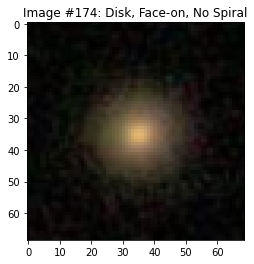

In [18]:
idx = 174
img = images_test[idx]
label = y_test[idx]

plt.imshow(img.astype('uint8').transpose((1, 2, 0))) and plt.title(f"Image #{idx}: {class_names[label]}") 
plt.savefig('Imagem #174', dpi = 400) and plt.show()

img_tensor = torch.from_numpy(img).unsqueeze(0)                # adiciona 4ª dimensão ao longo do primeiro eixo 
print(f"O tensor da imagem de entrada tem dimensões {img_tensor.size()}")
with torch.no_grad():                                          # Isso desativa a computação do gradiente (executa mais rápido)
    output = cnn(img_tensor.to(device))
print(f"A saída é um array de tamanho {output.size()}")
print(output)

O vetor de saída tem tantos valores quanto classes. A ativação $i$ indica o quanto o neurônio correspondente à classe $i$ foi excitado. Podemos usar o operador argmax para obter o índice da classe prevista pelo modelo. Podemos obter as classes classificadas com base em sua ativação:

In [19]:
class_idx = torch.argmax(output[0])
print(f"A classe prevista é: {class_idx} ({class_names[class_idx]})")

print(' ')

sorted_classes = np.argsort(-output[0].cpu().numpy())       # argsort diminuindo o valor
print(f"Outras previsões foram {[class_names[c] for c in sorted_classes]}")

A classe prevista é: 1 (Smooth, Completely round)
 
Outras previsões foram ['Smooth, Completely round', 'Disk, Face-on, No Spiral', 'Smooth, in-between round', 'Disk, Face-on, Medium Spiral', 'Disk, Face-on, Tight Spiral', 'Disk, Face-on, Loose Spiral', 'Disk, Edge-on, Rounded Bulge', 'Disk, Edge-on, Boxy Bulge', 'Smooth, Cigar shaped', 'Disk, Edge-on, No Bulge']


Assim como o `scikit-learn`, o skorch fornece uma função de pontuação integrada para que não precisemos fazer um loop em todas as amostras de teste manualmente:

In [20]:
accuracy = cnn_classifier.score(images_test, y_test)
print(f"Precisão CNN é {100*accuracy:.2f}%")

Precisão CNN é 71.20%


Usando o método `predict`, podemos mais uma vez obter as previsões para construir a matriz de confusão.

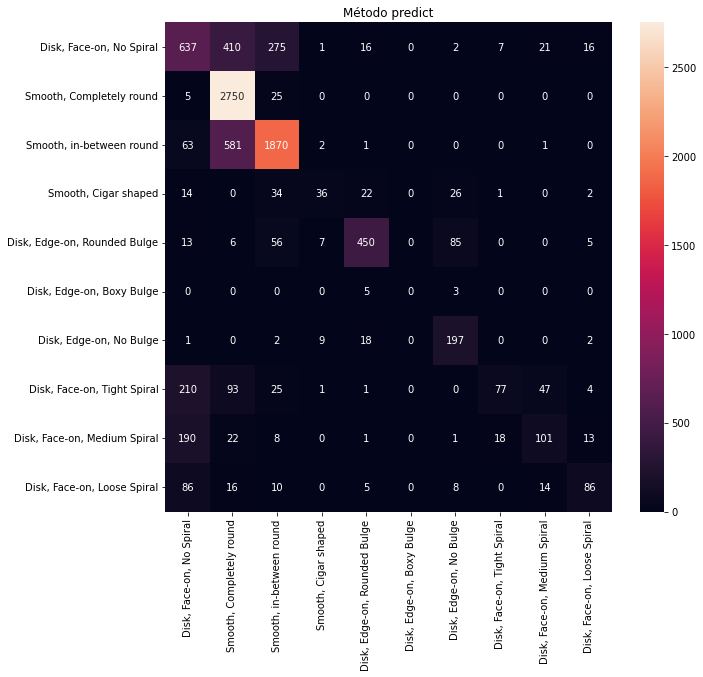

In [21]:
y_pred = cnn_classifier.predict(images_test)
show_G10_results(y_pred, y_test, title = 'Método predict')

Observe que a matriz de confusão não é apenas uma forma de avaliar uma classificação. A precisão nem sempre é a melhor métrica, especialmente quando os dados estão desequilibrados. Costumamos usar precisão e recall como métricas adicionais (também conhecidas como precisão e sensibilidade):

$$\text{Precisão}=\frac{\text{Verdadeiros positivos}}{\text{Verdadeiros positivos + Verdadeiros negativos}}$$

$$\text{Lembrete}=\frac{\text{Verdadeiros positivos}}{\text{Verdadeiros positivos + Falsos negativos}}$$

Essas métricas podem ser consolidadas na pontuação $F_{1}$, que é sua média harmônica: 

$$F_{1}=\frac{2V_{P}}{2V_{P}+F_{P}+F_{N}}$$

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, labels = range(0,10), target_names = class_names, zero_division = 0))

                              precision    recall  f1-score   support

    Disk, Face-on, No Spiral       0.52      0.46      0.49      1385
    Smooth, Completely round       0.71      0.99      0.83      2780
    Smooth, in-between round       0.81      0.74      0.78      2518
        Smooth, Cigar shaped       0.64      0.27      0.38       135
Disk, Edge-on, Rounded Bulge       0.87      0.72      0.79       622
   Disk, Edge-on, Boxy Bulge       0.00      0.00      0.00         8
     Disk, Edge-on, No Bulge       0.61      0.86      0.72       229
 Disk, Face-on, Tight Spiral       0.75      0.17      0.27       458
Disk, Face-on, Medium Spiral       0.55      0.29      0.38       354
 Disk, Face-on, Loose Spiral       0.67      0.38      0.49       225

                    accuracy                           0.71      8714
                   macro avg       0.61      0.49      0.51      8714
                weighted avg       0.71      0.71      0.69      8714



### 1.5 Trabalhando com o `PyTorch`

O `skorch` é um wrapper útil em torno do `PyTorch` que é compatível com o `scikit-learn`. No entanto, não permite o mesmo controle fino sobre o que está acontecendo do que trabalhar diretamente com o `torch`. Vamos ver como fazer a mesma coisa, mas sem o `skorch`. Isso também nos ajudará a entender um pouco mais o que está acontecendo ao treinar a rede neural

Já definimos a rede neural. Poderíamos ter usado a API da subclasse para definir nosso próprio módulo, mas, como a CNN que estamos usando é relativamente simples, manteremos o modelo Sequencial que definimos anteriormente.

Para trabalhar diretamente com o `PyTorch`, precisamos definir um objeto Dataset compatível com torch. O Dataset detalha como os dados são carregados na memória. Como já carregamos os dados no formato HDF5, podemos usar a ferramenta `TensorDataset`.

In [23]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(torch.from_numpy(images_train), torch.from_numpy(y_train))
test_ds = TensorDataset(torch.from_numpy(images_test), torch.from_numpy(y_test))

A principal funcionalidade dos Datasets é que eles são objetos iteráveis que retornam pares (amostra, rótulo):

In [24]:
for img, label in train_ds:
    print(f"Imagem: {img.size()}")
    print(f"Label: {label}")
    break

Imagem: torch.Size([3, 69, 69])
Label: 2


A descida de redes profundas é feita em lotes. A amostragem de lotes de exemplos do conjunto de dados é o trabalho do `DataLoader`:

In [25]:
train_loader = DataLoader(train_ds, batch_size = 128, shuffle = True, num_workers = 0)
test_loader = DataLoader(test_ds, batch_size = 128, shuffle = False, num_workers = 0)

Agora podemos definir uma função de treinamento que recebe uma rede e um DataLoader e realiza o treinamento de gradiente descendente:

In [26]:
def train(network, dataloader, epochs=10, lr=0.01, device=device):
    # Mova a rede para a GPU, se necessário
    network = network.to(device)
    
    # Defina o algoritmo de otimização (aqui, Stochastic Gradient Descent with momentum)
    optimizer = torch.optim.SGD(network.parameters(), lr=lr, momentum=0.9)
    
    # Defina a função de perda (no nosso caso, entropia cruzada)
    criterion = torch.nn.CrossEntropyLoss()
    
    # One epoch = uma passagem em todo o carregador de dados
    for e in tqdm(range(epochs), total = epochs): 
        # Isso coloca a rede neural em "modo de treinamento"
        network.train()

        # Para cada lote de exemplos, faça uma etapa do gradiente
        for batch, label in tqdm(dataloader, desc = f"Epoch {e+1}/{epochs}", leave = False):
            # Redefinir valores de gradiente
            optimizer.zero_grad()
            
            # Mova os tensores para a memória da CPU ou GPU
            batch, label = batch.to(device), label.to(device)
            
            # Passe para frente (obtenha previsões da rede)
            output = network(batch)
            # Calcular o erro entre previsões e rótulos verdadeiros
            loss = criterion(output, label)
            # Calcular os gradientes (passagem para trás)
            loss.backward()
            
            # Atualize os pesos (= um passo de descida do gradiente)
            optimizer.step()
    
    return network     



cnn = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size = (3,3), padding = 1),
    nn.MaxPool2d(kernel_size = (2, 2)),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size = (3,3), padding = 1),
    nn.MaxPool2d(kernel_size = (2, 2)),
    nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size = (3,3), padding = 1),
    nn.MaxPool2d(kernel_size = (2, 2)),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size = (3,3), padding = 1),
    nn.MaxPool2d(kernel_size = (2, 2)),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size = (3,3), padding = 1),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(256, 10))

train(cnn, train_loader, lr = 0.005, epochs = 50)



from sklearn.metrics import accuracy_score

def val(network, dataloader, device = device):
    criterion = torch.nn.CrossEntropyLoss()
    
    network = network.to(device)
    predictions = []
    labels = []
    loss = 0.
    
    with torch.no_grad():
        for batch, label in tqdm(dataloader):
            batch, label = batch.to(device), label.to(device)
            output = network(batch)
            loss += criterion(output, label)
            labels.append(label.cpu().numpy())
            predictions.append(torch.argmax(output, dim = 1).cpu().numpy())
            
    print(f"Perda média: {loss/len(labels)}")
    labels, predictions = np.concatenate(labels), np.concatenate(predictions)
    print(f"Precisão: {accuracy_score(labels, predictions)}")
    
    return predictions

val(cnn, test_loader)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Perda média: 1.033004879951477
Precisão: 0.7999770484278172


array([0, 2, 2, ..., 4, 0, 0], dtype=int64)

**OBS**: devido a algumas sutilezas na forma como o `skorch` lida com o treinamento, esse resultado não é diretamente comparável ao da CNN treinada com o `skorch`. Ambas as precisões devem, no entanto, estar no mesmo patamar, algumas porcentagens.

---

## 2. Saco de dicas e truques

### 2.1 Aumento de dados

O aumento de dados é usado para produzir novas amostras de treinamento a partir das existentes. Por exemplo, sabemos que inverter uma imagem de uma galáxia não altera o tipo de galáxia - dizemos que a tarefa de classificação de galáxias é *invariável à simetria*. Portanto, para uma única imagem, sabemos que suas versões invertidas e espelhadas são imagens aceitáveis da mesma classe:

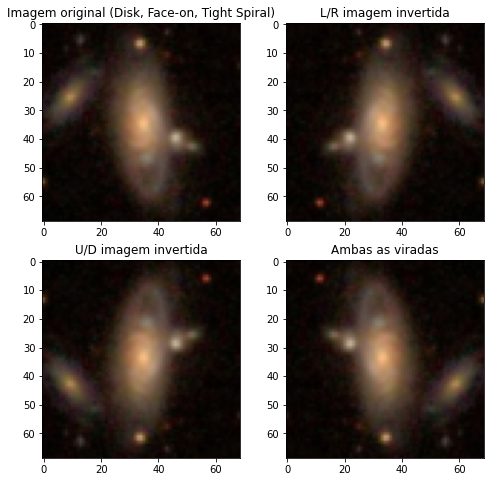

In [27]:
fig = plt.figure(figsize = (8,8))
img, l = images[9], class_names[labels[9]]

fig.add_subplot(221)
plt.imshow(img)
plt.title(f"Imagem original ({l})")
mirror = np.fliplr(img)

fig.add_subplot(222)
plt.imshow(mirror)
plt.title("L/R imagem invertida")
flip = np.flipud(img)

fig.add_subplot(223)
plt.imshow(flip)
plt.title("U/D imagem invertida")
both = np.fliplr(flip)

fig.add_subplot(224)
plt.imshow(both)
plt.title("Ambas as viradas")

plt.savefig('Original X L-R X U-D X Ambas.png', dpi = 400)
plt.show()

Para obter o aumento de dados em tempo real, precisamos definir um conjunto de dados personalizado no `PyTorch`. Felizmente para nós, isso não é muito difícil: precisamos principalmente definir um `Dataset` de subclasse de iterador que suporte o método `__getitem__()`. Veja o código abaixo:

In [28]:
from torch.utils.data import Dataset

class Galaxy10Dataset(Dataset):
    def __init__(self, data, targets, transform=None):
        super(Galaxy10Dataset, self).__init__()
        
        assert(len(data) == len(targets))
        self.data = data.astype('uint8')
        self.targets = targets
        self.transform = transform
    
    def __getitem__(self, index):
        
        img, target = self.data[index], self.targets[index]
        
        if self.transform is not None:
            img = 255 * self.transform(img)
        return img, target

    def __len__(self):
        return len(self.data) 

Toda vez que consultarmos o objeto do conjunto de dados para uma imagem, ele aplicará a função `transform` nele.

A função `torchvision` fornece algumas transformações comuns de imagem que podemos reutilizar. Nossa transformação geral é composta por quatro etapas:

1. Convertemos o array de imagens para o formato PIL para facilitar a manipulação,
2. Virar horizontalmente a imagem com probabilidade `p = 0.5`,
3. Virar verticalmente a imagem com probabilidade `p = 0.5`,
4. Extraia um corte aleatório de 64x64 da imagem (simule traduções aleatórias),
5. Converta a imagem PIL de volta para o tensor.

In [29]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(p = 0.5),
    transforms.RandomCrop((64, 64)),
    transforms.ToTensor()
])

Como exemplo, podemos aplicar manualmente o objeto `transform` em uma imagem de amostra para testar seu efeito. Repita esta célula várias vezes para ver a imagem à direita mudar dependendo das transformações aleatórias.

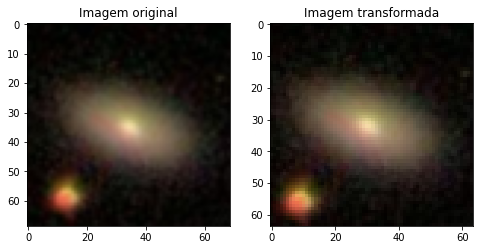

In [30]:
image = images_train[0].astype('uint8').transpose((1, 2, 0))
transformed_image = transform(image)

fig = plt.figure(figsize = (8,8))
fig.add_subplot(121)
plt.title("Imagem original")
plt.imshow(image)

fig.add_subplot(122)
plt.title("Imagem transformada")
plt.imshow(transformed_image.numpy().transpose((1, 2, 0))) 

plt.savefig('Original X Transformada', dpi = 400) and plt.show()

Agora, podemos finalmente construir um conjunto de dados de treinamento e o `DataLoader` correspondente que usará as imagens de treinamento e aplicará aleatoriamente o aumento de dados a elas.

In [31]:
train_augmented_ds = Galaxy10Dataset(images_train.transpose((0, 2, 3, 1)), y_train, transform = transform)

train_augmented_loader = DataLoader(train_ds, batch_size = 128, shuffle = True, num_workers = 0)

Ao incluir novas imagens correspondentes a espelhamento e inversão, praticamente multiplicamos por 3 o tamanho do conjunto de treinamento. Isso geralmente resulta em melhor generalização e maior precisão.

In [32]:
cnn = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size = (3, 3), padding = 1),
    nn.MaxPool2d(kernel_size = (2, 2)),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size = (3, 3), padding = 1),
    nn.MaxPool2d(kernel_size = (2, 2)),
    nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size = (3, 3), padding = 1),
    nn.MaxPool2d(kernel_size = (2, 2)),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size = (3, 3), padding = 1),
    nn.MaxPool2d(kernel_size = (2, 2)),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size = (3, 3), padding = 1),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(256, 10))

train(cnn, train_augmented_loader, lr = 0.005, epochs = 50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/103 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (8): ReLU()
  (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): AdaptiveAvgPool2d(output_size=(1, 1))
  (14): Flatten(start_dim=1, end_dim=-1)
  (15): Linear(in_features=256, out_features=10, bias=True)
)

Vamos dar uma olhada na nossa nova precisão:

  0%|          | 0/69 [00:00<?, ?it/s]

Perda média: 1.1570484638214111
Precisão: 0.8080100986917604


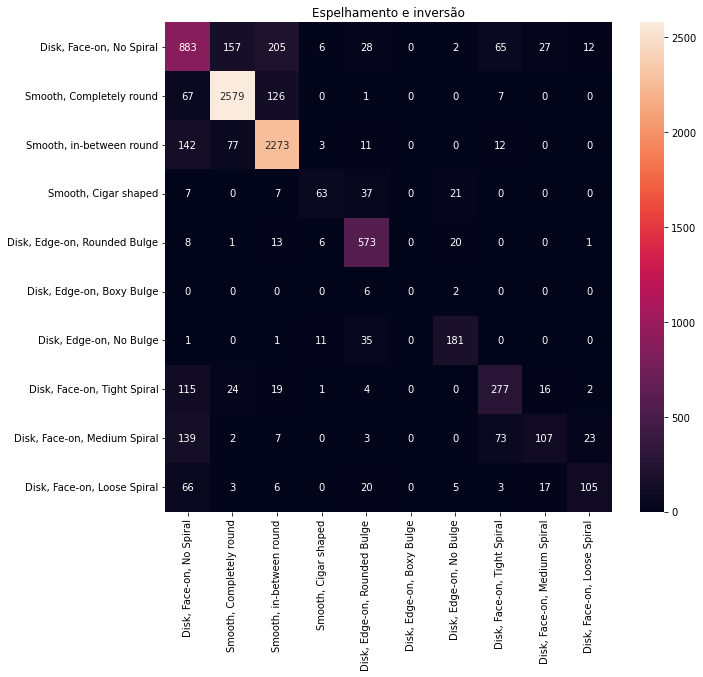

In [33]:
y_pred = val(cnn, test_loader)

show_G10_results(y_pred, y_test, title = 'Espelhamento e inversão')

**Dica 5**: mais dados sempre vencem um algoritmo inteligente. Quando puder, use o aumento de dados para aumentar o tamanho do conjunto de dados.

### 2.2 Afinação

Um dos pontos fortes das caixas de ferramentas de aprendizado profundo é que muitos modelos de última geração já foram implementados. Por exemplo, usando a biblioteca `torchvision`, é simples reutilizar a arquitetura de rede residual profunda (**ResNet**) desenvolvida por [Kaiming He *et al*. em 2015](https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf) [8].

In [34]:
from torchvision.models import resnet18, resnet34, resnet50

resnet = resnet18()

cnn_classifier = skorch.classifier.NeuralNetClassifier(resnet,
                                                       lr = 0.01,
                                                       optimizer__momentum = 0.9,
                                                       max_epochs = 50,
                                                       criterion = nn.CrossEntropyLoss,
                                                       device = device)
cnn_classifier.fit(images_train, y_train)
cnn_classifier.score(images_test, y_test)

  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        1.5978       0.4141        1.8769  222.3436
      2        0.8878       0.6727        0.8821  219.5152
      3        0.7683       0.2444        2.3868  217.8331
      4        0.6786       0.4883        1.3348  214.5358
      5        0.6306       0.6279        0.9927  217.4511
      6        0.5735       0.7124        0.8805  220.6988
      7        0.5099       0.4822        2.9924  222.9583
      8        0.4714       0.7457        0.7743  188.1012
      9        0.4417       0.5813        1.1990  185.3150
     10        0.3872       0.3641        2.2925  187.1500
     11        0.3321       0.4130        2.5395  184.6580
     12        0.2880       0.5855        1.6789  181.4450
     13        0.2769       0.6604        1.2286  213.8185
     14        0.2725       0.7143        1.3449  208.2846
     15        0.2421       0.7101        1.2374  191.08

0.7850585265090658

O que é ainda melhor é que a maioria dos modelos já foi treinada para classificação de imagens no [ImageNet](https://image-net.org). ImageNet contém 1 milhão de imagens para 1.000 classes de objetos, desde telefones e cadeiras até gatos e cachorros. Obviamente, os modelos treinados no ImageNet não podem ser usados diretamente para classificação de galáxias.

No entanto, podemos **afinar** para aproveitar o que o modelo aprendeu para classificação genérica de imagens no ImageNet e especializá-lo no conjunto de dados `Galaxy10`.

Por exemplo, podemos carregar os pesos do modelo pré-treinado no ImageNet e usá-los como ponto de partida para treinar a rede no `Galaxy10`. Isso geralmente resulta em um treinamento mais rápido (já que a rede já sabe muito sobre classificação de imagens) e o modelo geralmente tem um desempenho melhor.

In [35]:
from torchvision.models import resnet18, resnet34, resnet50

# pretrained = True irá carregar o modelo com pesos obtidos pelo treinamento no ImageNet
resnet = resnet18(pretrained = True)

cnn_classifier = skorch.classifier.NeuralNetClassifier(resnet,
                                                       lr = 1e-4,        # menor taxa de aprendizado
                                                       optimizer__momentum = 0.99,
                                                       max_epochs = 10,  # apenas 10 épocas em vez de 50
                                                       criterion = nn.CrossEntropyLoss,
                                                       device = device)
cnn_classifier.fit(images_train, y_train)
cnn_classifier.score(images_test, y_test)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Gabriel Wendell/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        5.4636       0.5641        1.7617  192.2920
      2        1.0855       0.6688        0.9473  212.7990
      3        0.7222       0.7576        0.7036  213.5538
      4        0.5743       0.7893        0.6346  215.0660
      5        0.4830       0.8107        0.5644  207.9070
      6        0.4102       0.8034        0.5605  226.3715
      7        0.3403       0.7889        0.6118  213.7782
      8        0.2857       0.8008        0.6149  195.3658
      9        0.2362       0.8122        0.6448  191.3613
     10        0.2002       0.7924        0.7997  192.1162


0.7913702088593069

Alcançamos uma precisão semelhante, mas em menos épocas. Os pesos pré-treinados deram a este modelo uma vantagem inicial para o treinamento.

**Dica 6**: use modelos pré-treinados quando eles existirem para treinamento mais rápido e melhor generalização (na maioria dos casos). Para classificação de imagens, existem muitos modelos pré-treinados SOTA disponíveis online.

Usando essa ideia, podemos alavancar modelos grandes com eficiência, mesmo com poder computacional limitado. Por exemplo, podemos treinar um grande modelo `DenseNet` em algumas épocas:

In [36]:
from torchvision.models import densenet121

# pretrained = True irá carregar o modelo com pesos obtidos pelo treinamento no ImageNet
densenet = densenet121(pretrained = True)

cnn_classifier = skorch.classifier.NeuralNetClassifier(densenet,
                                                       lr = 1e-4,         # menor taxa de aprendizado
                                                       optimizer__momentum=0.99,
                                                       max_epochs = 6,    # apenas 6 épocas
                                                       criterion = nn.CrossEntropyLoss,
                                                       device = device)
cnn_classifier.fit(images_train, y_train)
cnn_classifier.score(images_test, y_test)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\Gabriel Wendell/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        5.7384       0.6134        2.2161  477.2883
      2        1.0663       0.7231        0.9593  481.4952
      3        0.6941       0.7759        0.6770  469.6411
      4        0.5634       0.7954        0.6005  480.7229
      5        0.4658       0.8103        0.5383  475.5049
      6        0.3863       0.8157        0.5371  543.5766


0.8072067936653661

Vamos dar uma olhada na matriz de confusão...

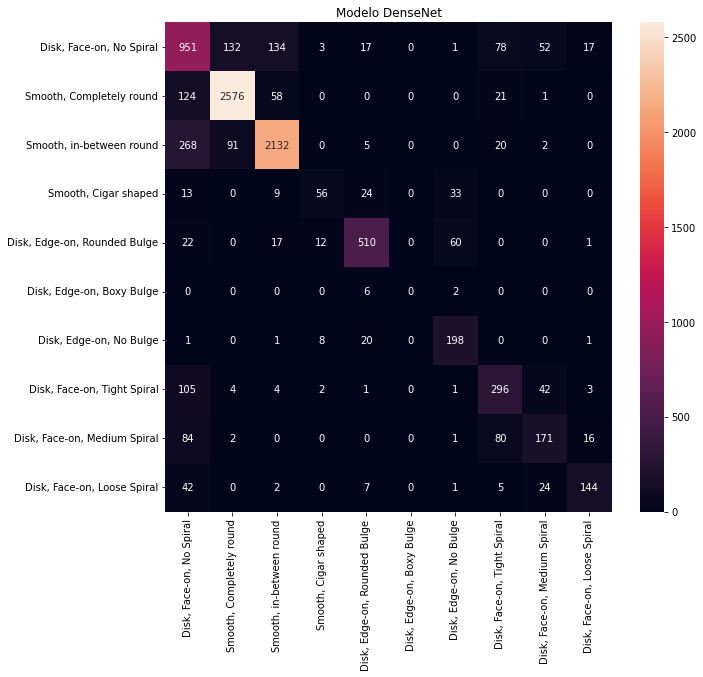

In [37]:
show_G10_results(cnn_classifier.predict(images_test), y_test, title = 'Modelo DenseNet')

### 2.3 Jogando com recursos profundos

As representações internas que as redes neurais constroem podem ser usadas como descritores muito eficazes para clustering e mineração de dados. Por exemplo, este bloco demonstrará como extrair ativações intermediárias (recursos, ou *features*) da CNN treinada no `Galaxy10` para uso na recuperação de imagens e visualização 2D.

Para começar, precisamos extrair recursos para todas as imagens do nosso conjunto de dados. Escrevemos uma função auxiliar curta para conseguir isso.

In [38]:
feat_extractor = nn.Sequential(*list(cnn_classifier.module.children())[0][:-1])

def extract_features(network, dataset, batch_size = 128, transpose = True, device = 'cpu'):
    bs = batch_size
    network = network.to(device)
    features = np.zeros((len(dataset), 1024), dtype = 'float32')
    
    with torch.no_grad():
        for idx in tqdm(range(len(dataset) // bs)):
            data = dataset[idx*bs:idx*bs + bs]
            if transpose:
                data = data.transpose((0, 3, 1, 2))
                
            batch = torch.from_numpy(data).to(device)
            features[idx*bs:idx*bs+bs] = network(batch).cpu().numpy().mean(axis = (2,3))
            
    return features



train_features = extract_features(feat_extractor, images_train, transpose = False, device = device)
test_features = extract_features(feat_extractor, images_test, transpose = False, device = device)

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

#### 2.3.1 Encontrando imagens semelhantes

Para cada imagem no conjunto de dados, agora temos um vetor de 1024 que a descreve. Por si só, esse vetor não é muito útil.

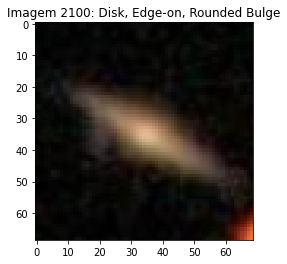

In [39]:
i = 2100

plt.imshow(images_test[i].transpose((1, 2, 0)).astype('uint8'))
plt.title(f"Imagem {i}: {class_names[y_test[i]]}")
plt.savefig('Imagem #2100.png', dpi = 400) and plt.show()

Se considerarmos que este vetor representa um ponto em um espaço euclidiano de dimensão 1024, poderíamos para seus vizinhos mais próximos.

Vamos encontrar os 4 vizinhos mais próximos desta imagem em nosso conjunto de dados.

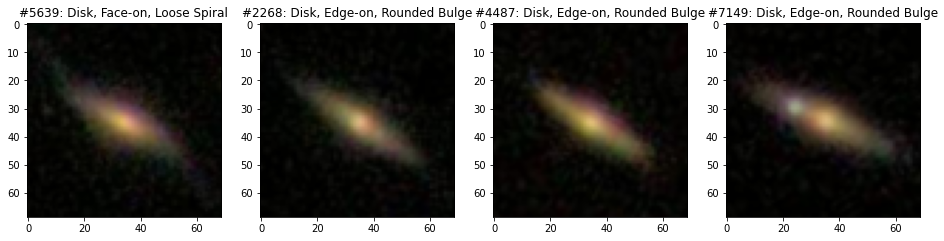

In [40]:
def find_closest_image(query, features):
    distances = [np.linalg.norm(query - f) for f in features]
    
    return np.argsort(distances)

nearest = find_closest_image(test_features[i], test_features)

fig = plt.figure(figsize = (16, 8))
for idx, i in enumerate(nearest[1:5]):
    fig.add_subplot(1,4,idx+1)
    plt.imshow(images_test[i].transpose((1, 2, 0)).astype('uint8'))
    plt.title(f"#{i}: {class_names[y_test[i]]}")
plt.savefig('Nearest Neighbours - Imagem #2100.png', dpi = 400) and plt.show()

Agradável! Esta função retornou imagens visualmente bastante semelhantes à nossa imagem de "consulta". Isso pode ser muito útil para detectar quase duplicatas ou para encontrar imagens que se parecem com outras coisas.

#### 2.3.2 Visualizando o espaço da imagem

Se você se lembra, no início do `Notebook` *Classificação espectral de estrelas usando Machine Learning* [1] usamos o PCA como algoritmo de redução de dimensão. Por que não usar a mesma abordagem de antes para projetar nossos vetores de recursos profundos em um espaço 2D para que possamos visualizar nossos dados usando uma nuvem de pontos?

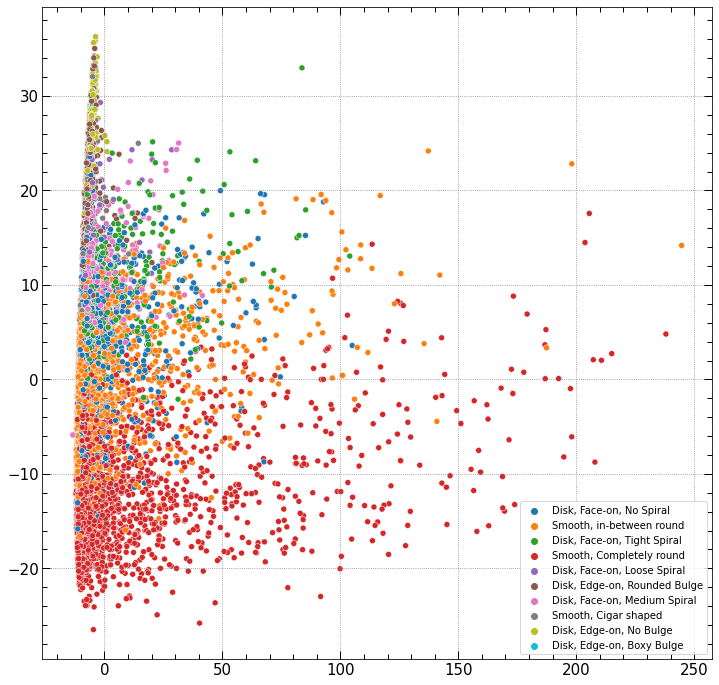

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

scaler = StandardScaler()
pipeline = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components = 2))])
X = pipeline.fit_transform(test_features)

fig = plt.figure(figsize = (12, 12))
sns.scatterplot(x = X[:,0], y = X[:, 1], hue = np.array([class_names[y] for y in y_test]))
opt_plot()
plt.savefig('Espaço de imagem 2D.png', dpi = 400) and plt.show()

Está funcionando. Agora podemos entender um pouco melhor como a rede "vê" as imagens. Alguns tipos de galáxias foram agrupados em torno do mesmo ponto, enquanto outros estão estranhamente muito distantes de outras imagens supostamente semelhantes. Talvez essas imagens sejam discrepantes por causa do ruído/artefatos do sensor ou porque os objetos são estranhos.

No entanto, o PCA não é muito eficaz em recursos profundos porque as ativações provavelmente não são correlacionadas linearmente. Existem técnicas de redução de dimensão mais poderosas que realizam desembaraçamento não linear, como t-SNE e UMAP.

O t-SNE é implementado no `scikit-learn`, então é fácil experimentá-lo (**aviso**: é um pouco lento, então seja paciente):

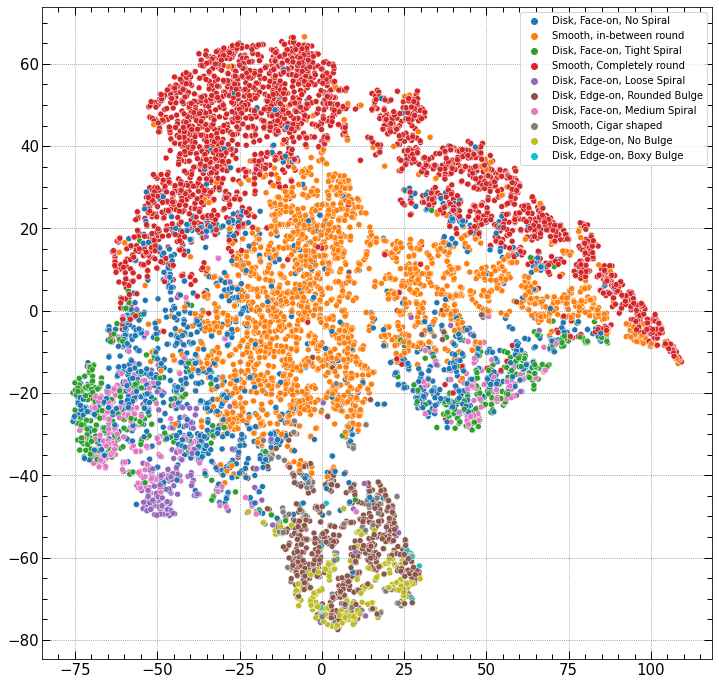

In [43]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, perplexity = 30.0, n_jobs = 4)
X = tsne.fit_transform(test_features)
fig = plt.figure(figsize = (12, 12))
sns.scatterplot(x = X[:,0], y = X[:, 1], hue = np.array([class_names[y] for y in y_test]))
opt_plot()
plt.savefig('t-SNE.png') and plt.show()

Isso é mais útil. Isso dá uma ideia da topologia subjacente dos dados: quais imagens estão próximas de outras? Algumas classes são misturadas e difíceis de separar?

Por exemplo, podemos ver que algumas classes são bastante bem delineadas (por exemplo, galáxias redondas suaves), enquanto o modelo parece confundir muito as várias galáxias de disco. Mais especificamente, as galáxias de disco de borda parecem ser confundidas com galáxias lisas em forma de charuto. Isso é consistente com a matriz de confusão e pode nos ajudar a "depurar" os erros cometidos pela rede.

Como uma alternativa mais rápida e escalável ao t-SNE, o UMAP mais recente pode ser uma boa escolha. As formas diferem, mas as posições relativas das classes devem permanecer as mesmas.

UMAP está disponível em seu próprio pacote Python (`umap-learn`), mas usa a convenção scikit-learn para que você possa simplesmente colocá-lo em seu código como qualquer outro estimador `sklearn`.

 ```Python
In [44]:
from umap import UMAP

um = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.1)
X = um.fit_transform(test_features)

fig = plt.figure(figsize = (12, 12))
sns.scatterplot(x = X[:,0], y = X[:, 1], hue = np.array([class_names[y] for y in y_test]))  #, palette = plt.cm.tab10)
opt_plot()
plt.savefig('UMAP.png', dpi = 400) and plt.show()
```

---

## 3. Indo um pouco mais fundo...

### 3.1 API de subclassificação

A API `Sequential` do `PyTorch` também pode ser usada para definir redes neurais topologicamente simples. No entanto, é possível ter controle total sobre a arquitetura da rede neural usando a API de subclassificação. Em seu núcleo, esta API consiste em criar subclasses da classe base torch.nn.Module utilizando Python.

Tal modelo deve ter pelo menos dois métodos: `__init__()` (que cria o modelo) e `forward()` que executa a passagem para trás.

`PyTorch` usa diferenciação automática. Isso significa que os gradientes durante o `backward()` são calculados automaticamente, desde que você use operadores de tocha! Isso torna muito fácil definir redes personalizadas e até mesmo camadas personalizadas.

Veja abaixo um exemplo de como definir nosso `Galaxy10` CNN usando a API de subclassificação:

```Python
In [45]:
import torch.nn.functional as F

class G10CNN(nn.Module):
    def __init__(self, num_classes = 10):
        # Cria o núcleo do módulo
        super(G10CNN, self).__init__ 
        self.conv1 = nn.Conv2d(3, 64, kernel_size = (3, 3), padding = 1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = (3, 3), padding = 1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = (3, 3), padding = 1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size = (3, 3), padding = 1),
        self.conv5 = nn.Conv2d(256, 256, kernel_size = (3, 3), padding = 1)
        # Como o Maxpooling não tem parâmetros, nós o definimos apenas uma vez
        self.maxpool = nn.MaxPool2d(kernel_size = (2, 2))
    
        
        # We can also combine modules
        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),
                                        nn.Flatten(),
                                        nn.Linear(256, num_classes))
    
    def forward(self, x):
        # Isso define o passe para frente
        # Aplicamos todas as camadas em sucessão, mas criamos um gráfico mais complexo
        x = self.conv1(x)
        # Podemos aplicar ReLU como uma função em vez de definir uma camada
        x = F.relu(self.maxpool(x))
        x = self.conv2(x)
        x = F.relu(self.maxpool(x))
        x = self.conv3(x)
        x = F.relu(self.maxpool(x))
        x = self.conv4(x)
        x = F.relu(self.maxpool(x))
        x = self.conv5(x)
        # Classificação final (Average Pooling + Flatten + linear classifier)
        x = self.classifier(x)
        return x

subclassed_cnn = G10CNN(num_classes = 10)
```

### 3.2 Construindo uma pipeline

O `scikit-learn` fornece uma boa ferramenta para pipelines de ML com várias etapas. O processamento de dados em uma sequência de vários estimadores (por exemplo, padronização + redução de dimensão + agrupamento) pode ser propenso a erros. Por exemplo, um erro muito comum é usar a padronização durante o treinamento, mas não durante a inferência. Outro erro consiste em usar dados de teste para ajustar um estimador por engano.

Agrupar todas as etapas em um `Pipeline` torna o código mais simples, fácil de ler e menos propenso a erros. Veja o exemplo abaixo para um pipeline simples.

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

tree = DecisionTreeClassifier()

pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components = 2)), ('tree', DecisionTreeClassifier())])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.3812256139545559

### 3.3 Recursos profundos na prateleira

Um uso interessante de redes neurais profundas é a extração de recursos. Em vez de projetar recursos especializados, como HOGs, você pode usar uma rede neural profunda pré-treinada de última geração, aplicá-la em seus dados e usar as ativações da última camada como um vetor de recursos. Isso aproveita o poderoso modelo pré-treinado que aprendeu em um conjunto de dados muito grande como são as imagens.

É claro que a maioria dos modelos pré-treinados são treinados para classificação em imagens cotidianas para classes como gatos, cachorros, telefones e assim por diante. Mas os filtros convolucionais que esses modelos aprenderam são frequentemente muito expressivos e transferem para muitos domínios!

Pode ser útil se você se enquadrar em um dos seguintes casos de uso:

- se você não tiver o poder computacional para treinar redes profundas sozinho,
- você não quer projetar uma rede neural e mexer com otimização,
- você não tem muitos dados.

Vamos ver como se pode usar um modelo pré-treinado como um extrator de recursos. Em seguida, usaremos o pipeline de classificação SVM usual para treinar um classificador de galáxias usando recursos profundos (mas nunca precisando treinar novamente a rede).

In [52]:
from tqdm import trange
from torchvision.models import densenet121

feature_net = nn.Sequential(*densenet121(pretrained = True).features[:-1])

features_train = extract_features(feature_net, images_train, transpose = False)

  0%|          | 0/102 [00:00<?, ?it/s]

Vamos dar uma olhada no formato...

In [53]:
features_train.shape

(13071, 1024)

Seguindo com nossa "brincadeira":

In [55]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(features_train)

#, 'kernel': ['linear', 'rbf'], 'gamma': ['auto', 'scale']
grid = {'C': [1e-2, 0.1, 1.0, 10, 100, 1000, 10000]}
model = GridSearchCV(LinearSVC(), grid, verbose = 1, n_jobs = 6)
model.fit(features_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(estimator=LinearSVC(), n_jobs=6,
             param_grid={'C': [0.01, 0.1, 1.0, 10, 100, 1000, 10000]},
             verbose=1)

Com relação ao conjunto de teste...

In [56]:
features_test = extract_features(feature_net, images_test, transpose = False)

  0%|          | 0/68 [00:00<?, ?it/s]

Para finalizar, um teste de precisão para o nosso modelo:

```Python
In [51]:
svm.score(scaler.transform(features_test), y_test)

Out[51]:
0.5906587101216433    

```

No nosso caso, os recursos profundos prontos para uso não funcionam muito bem, talvez porque a lacuna semântica entre o ImageNet e o `Galaxy10` seja muito grande.

---

## 4. Ao infinito e além!

Esta seção detalha principalmente alguns ponteiros e palavras-chave para alguns tópicos interessantes que não foram abordados neste `Notebook`.

### 4.1 Regressão

Embora isso não tenha sido detalhado neste tutorial, não há limitações que impeçam que redes neurais profundas sejam usadas para regressão. Em vez de ter $k$ neurônios (um para cada classe), a camada de saída pode ter tantos neurônios quanto variáveis contínuas de destino para prever.

A função de perda pode ser trocada para usar, por exemplo, o erro quadrático médio ou qualquer outra medida de erro que seja diferenciável (para que um gradiente possa ser calculado).

### 4.2 Aprendizado profundo não supervisionado

As redes neurais profundas podem funcionar sem supervisão. Isso pode ser muito útil para aprender representações quando os dados não são rotulados, por exemplo. para recuperação ou agrupamento de imagens.

O exemplo seminal de redes neurais não supervisionadas é o [autoencoder](https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798) [9], onde o modelo aprende a compactar os dados e depois reconstruí-los para minimizar o erro de reconstrução.

### 4.3 ML em séries temporais/dados espectrais

Os dados temporais ou espectrais que podem ser representados como vetores 1-D podem ser processados de forma semelhante aos dados tabulares. No entanto, outros modelos específicos podem ser bastante adequados para este tipo de dados homogêneos:

- Redes neurais convolucionais 1D para [séries temporais](https://arxiv.org/pdf/1809.04356.pdf) [10] ou para [dados espectrais](https://www.mdpi.com/2220-9964/8/4/160/pdf) [11],
- Redes neurais recorrentes, ou seja, redes neurais com memória temporal, especialmente úteis para séries temporais (ver, por exemplo, a [arquitetura LSTM](https://direct.mit.edu/neco/article-abstract/31/7/1235/8500/A-Review-of-Recurrent-Neural-Networks-LSTM-Cells?redirectedFrom=fulltext) [12] de [Hochreiter e Schmidhuber, 1997](https://direct.mit.edu/neco/article-abstract/9/8/1735/6109/Long-Short-Term-Memory?redirectedFrom=fulltext) [13]).
- Caixas de ferramentas dedicadas para séries temporais, como [`tslearn`](https://tslearn.readthedocs.io/en/stable/), desenvolvidas por Romain Tavenard.

### 4.4 Modelos generativos e estimativa de densidade

Às vezes, apenas a classificação ou regressão não é suficiente. [*Modelos de mistura gaussiana*](https://scikit-learn.org/stable/modules/mixture.html) [14] são uma ferramenta muito útil para estimar a *função de densidade de probabilidade* de seus dados. Você pode até mesmo amostrar novos dados do PDF aproximado.

Indo um passo adiante, as Redes Adversariais Generativas usam duas redes neurais em competição. O *Gerador* tenta criar novos dados que enganam o *Discriminador* (ou *Crítico*), que tenta separar dados falsos de dados reais. Veja, por exemplo, o artigo original de [Goodfellow et al. 2015](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) [15] pela ideia.

---

## Referências

- [1] *Classificação espectral de estrelas usando Machine Learning*: https://github.com/GabrielWendell/PET.py/blob/main/Notebooks/Classificação%20espectral%20estelar%20usando%20ML.ipynb

- [2] *Discrete Wavelet Transform*: https://www.sciencedirect.com/topics/mathematics/discrete-wavelet-transform

- [3] *Creating Histograms*: https://datacarpentry.org/image-processing/05-creating-histograms/

- [4] *Navneet Dalal, Bill Triggs. Histograms of Oriented Gradients for Human Detection. International
Conference on Computer Vision & Pattern Recognition (CVPR ’05), Jun 2005, San Diego, United
States. pp.886 – 893* : https://hal.inria.fr/inria-00548512/document

- [5] *What is Perceptron: A Beginners Guide for Perceptron*: https://www.simplilearn.com/tutorials/deep-learning-tutorial/perceptron#:~:text=A%20Perceptron%20is%20a%20neural,value%20”f(x).

- [6] *Glorot et al., Deep Sparse Rectifier Neural Networks* : http://proceedings.mlr.press/v15/glorot11a/glorot11a.pdf

- [7] *LeNet-5, convolutional neural networks* : http://yann.lecun.com/exdb/lenet/

- [8] *Kaiming He et al, Deep Residual Learning for Image Recognition* : https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf

- [9] *Applied Deep Learning - Part 3: Autoencoders* : https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798

- [10] *Ismail Fawaz, H., Forestier, G., Weber, J. et al. Deep learning for time series classification: a review. Data Min Knowl Disc 33, 917–963 (2019).* : https://doi.org/10.1007/s10618-019-00619-1

- [11] *Liu, B.; Li, Y.; Li, G.; Liu, A. A Spectral Feature Based Convolutional Neural Network for Classification of Sea Surface Oil Spill. ISPRS Int. J. Geo-Inf. 2019, 8, 160.* : https://doi.org/10.3390/ijgi8040160

- [12] *Yong Yu, Xiaosheng Si, Changhua Hu, Jianxun Zhang; A Review of Recurrent Neural Networks: LSTM Cells and Network Architectures. Neural Comput 2019; 31 (7): 1235–1270.* : https://doi.org/10.1162/neco_a_01199

- [13] *Sepp Hochreiter, Jürgen Schmidhuber; Long Short-Term Memory. Neural Comput 1997; 9 (8): 1735–1780.* : https://doi.org/10.1162/neco.1997.9.8.1735

- [14] *Gaussian mixture models* : https://scikit-learn.org/stable/modules/mixture.html

- [15] *Goodfellow, Ian, et al. "Generative adversarial networks." Communications of the ACM 63.11 (2020): 139-144.* : https://doi.org/10.48550/arXiv.1406.2661

---